# Blending CNN and LSTM

In [1]:
import numpy as np
import tensorflow as tf
import random as python_random

In [2]:
np.random.seed(1)
python_random.seed(12)
tf.random.set_seed(123)

In [3]:
# importing useful libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re

import time 

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

# importing deep learning libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GlobalMaxPool1D, Conv1D, Dropout, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from gensim.models import Word2Vec # importing Word2Vec

### Downloading the data from our github repository

In [4]:
url1 = 'https://raw.github.com/HamoyeHQ/stage-f-06-wine-tasting/master/data/top_40_varieties.zip'
url2 = 'https://raw.github.com/HamoyeHQ/stage-f-06-wine-tasting/master/data/top_varieties_count.csv'

In [5]:
top_40_varieties = pd.read_csv(url1)
top_varieties_count = pd.read_csv(url2)

In [6]:
# replacing every occurence of 'US' in country with 'United States of America'
top_40_varieties['country'].replace('US', 'United States of America', inplace=True)

# replacing every occurence of 'US' in not_vintage with 'United States of America'
top_40_varieties['not_vintage'] = top_40_varieties['not_vintage'].apply(lambda x: x.replace(\
                                                                        'US', 'United States of America'))

In [7]:
# renaming the columns in top_varieties_count
top_varieties_count = top_varieties_count.rename(columns={'variety': 'count', 'Unnamed: 0': 'variety'})
top_varieties_count = top_varieties_count.set_index('variety') # setting the index
top_varieties_count = top_varieties_count['count'] # making it a Series

In [8]:
top = 20 # selecting top 20 varities as our working varieties. note 1 < n <= 40

# making a datframe of our selecting top n varieties
top_df = top_40_varieties[top_40_varieties['variety'].isin(top_varieties_count.iloc[:top].index)]

In [9]:
# threshold of miniority variety to over sample (use sentences as document instead of the whole description)
minority_threshold = 5000 

# making a dataframe of the miniority classes
minority_df = top_df[top_df['variety'].isin(top_varieties_count[top_varieties_count < \
                                                                      minority_threshold].index)]

In [10]:
from nltk.tokenize import sent_tokenize # importing useful library

In [11]:
oversampled_miniority_lst = [] # empty list to store sentences as tokens miniority corpus

# creating a function to use sentences as tokens for the miniority classes
def over_sample_miniority(row):
    doc_list = sent_tokenize(row['description'])
    for sent in doc_list:
        row['description'] = sent
        oversampled_miniority_lst.append(list(row))

In [12]:
minority_df.apply(over_sample_miniority, axis=1); # over sample the miniority classes

In [13]:
# converts oversampled_miniority_lst to a dataframe
oversampled_miniority_df = pd.DataFrame(oversampled_miniority_lst, columns=minority_df.columns)

In [14]:
# selecting majority classes as a dataframe to concatenate to oversampled_miniority_lst
majority_df = top_df[top_df['variety'].isin(\
                                        top_varieties_count[top_varieties_count >= minority_threshold].index)]

# concatenates majority_df to oversampled_miniority_lst
balanced_df = pd.concat([majority_df, oversampled_miniority_df]) 
balanced_df = balanced_df.reset_index().drop('index', axis=1) # resets index

In [15]:
balanced_variety = balanced_df['variety'].value_counts() # gets a Series of the variety count in balanced_df

In [16]:
# for sentence oversampling
sent_oversample_corpus = [doc1 + ' ' + doc2 for doc1, doc2 in zip(\
                                                        balanced_df['description'], balanced_df['not_vintage'])]

In [17]:
labels = [label for label in balanced_df['variety']]

## Here is our workflow. It tells the whole story. (source: our github repo)

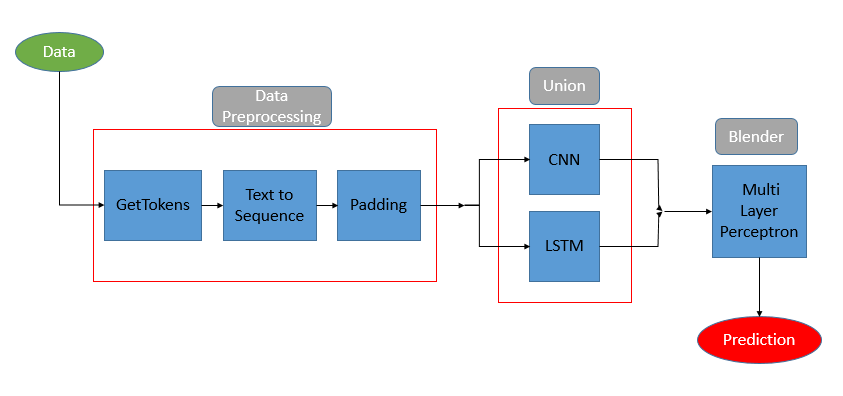

## 2.0 Data Preprocessing

In [18]:
import spacy

In [19]:
# creating a spacy pipeline and disabling tagger, parser and ner to speed up tokenizer
nlp = spacy.load('en', disable=['tagger', 'parser', 'ner']) 

In [20]:
spacy_stop_words = spacy.lang.en.STOP_WORDS # getting spacy's stop-words

In [21]:
# downloading yoast_stop_words to be included to spacy's stop words to improve performance
response = requests.get('https://raw.github.com/Yoast/YoastSEO.js/develop/src/config/stopwords.js')
yoast_stop_words = response.content.decode()

In [22]:
yoast_stop_words

'/** @module config/stopwords */\n\n/**\n * Returns an array with stopwords to be used by the analyzer.\n *\n * @returns {Array} stopwords The array filled with stopwords.\n */\nexport default function() {\n\treturn [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he\'d", "he\'ll", "he\'s", "her", "here", "here\'s", "hers", "herself", "him", "himself", "his", "how", "how\'s", "i", "i\'d", "i\'ll", "i\'m", "i\'ve", "if", "in", "into", "is", "it", "it\'s", "its", "itself", "let\'s", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she\'d", "she\'ll", "she\'s", "should", "so", "some", "such", "than", "t

In [23]:
pattern = r'\[.+\]'
match = re.search(pattern, yoast_stop_words)
yoast_stop_words = set(match.group()[1:-1].replace('"', '').replace(',', '').split())
print(f'length of yoast_stop_words is {len(yoast_stop_words)}\n')
print(yoast_stop_words)

length of yoast_stop_words is 153

{'own', 'down', 'only', 'and', 'than', 'after', 'themselves', 'of', 'could', "i'll", 'itself', 'this', 'while', 'they', 'with', 'once', 'she', 'as', 'nor', 'himself', 'more', 'then', 'being', 'your', "they'll", 'into', 'here', "he'd", 'against', 'on', 'whom', "you'll", 'ourselves', 'such', "here's", 'theirs', 'ours', "who's", "you're", 'these', 'were', 'yours', 'few', 'from', "how's", 'its', 'is', "you'd", 'between', "he's", "that's", 'it', 'very', 'yourselves', "they've", 'where', "i'm", 'because', 'their', 'does', 'did', 'that', 'an', 'ought', 'other', 'the', "she'd", 'what', 'would', 'be', 'have', 'are', 'same', 'my', "he'll", "i'd", 'below', 'in', "they're", 'or', 'when', 'should', 'each', 'who', 'to', 'doing', 'too', 'so', 'had', 'our', 'some', 'herself', 'been', 'out', 'by', 'further', 'her', 'how', 'about', 'but', 'he', "we've", 'both', 'having', 'above', "she's", 'his', "there's", 'over', "why's", 'am', 'do', 'before', 'under', "you've", "it's

In [24]:
stop_words_lemma = {word.lemma_.lower() for word in nlp(' '.join(spacy_stop_words | yoast_stop_words))} | \
{'-pron-', '10', '12', 'aah', 'aa', 'ab', 'aaa', 'aand', '16', '2', '20', '30', '4', '40', '5', '6', '7', \
 '8', '9'}

## Creating custom transformers to encapsulate our data preprocessing

In [25]:
class GetTokens(BaseEstimator, TransformerMixin):
    def __init__(self, stop_words=stop_words_lemma):
        self.stop_words = stop_words
    
    # defining tokenzer function to tokenize the lower case lemma of documents in a corpus and 
    # filter out stop-words  
    def tokenize(self, text):
        return [word.lemma_.lower() for word in nlp(text) if word.is_alpha and word.lemma_.lower() \
                not in self.stop_words]

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        self.tokens = [self.tokenize(doc) for doc in X]
            
        return self.tokens

In [26]:
tokens = GetTokens()

In [27]:
class Text2Sequence(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.sequence_tokenizer = Tokenizer(oov_token='<oov>')

    def fit(self, X, y=None):
        self.sequence_tokenizer.fit_on_texts(X)
        self.words_indices = self.sequence_tokenizer.word_index
        return self
    
    def transform(self, X):
        self.get_sequences = self.sequence_tokenizer.texts_to_sequences(X)
        return self.get_sequences

In [28]:
text_2_seq = Text2Sequence()

In [29]:
class Padding(BaseEstimator, TransformerMixin):
    def __init__(self, pad='post'):
        self.pad = pad
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        self.get_paddings = pad_sequences(X, padding=self.pad)
        return self.get_paddings

In [30]:
pad = Padding()

In [31]:
data_prep_pipe = Pipeline([('get_tokens', tokens), ('text_2_sequence', text_2_seq), ('padding', pad)], verbose=1)

In [32]:
le = LabelEncoder()
one_hot = OneHotEncoder(sparse=False) 
        
encoded_labels = le.fit_transform(labels)
one_hot_labels = one_hot.fit_transform(encoded_labels.reshape(-1, 1))

In [33]:
X_prep = data_prep_pipe.fit_transform(sent_oversample_corpus) # getting processed corpus

[Pipeline] ........ (step 1 of 3) Processing get_tokens, total= 1.2min
[Pipeline] ... (step 2 of 3) Processing text_2_sequence, total=   6.4s
[Pipeline] ........... (step 3 of 3) Processing padding, total=   1.8s


## Training

In [34]:
# defining a function to return the emdedding matrix of our word2vec
def get_embedding_matrix(model, word_index):
    vocab_size = len(word_index) + 1
    embedding_dim = model.wv.vector_size
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    for word in model.wv.vocab:
        ind = word_index[word]
        embedding_matrix[ind] = model[word]
        
    return embedding_matrix

In [35]:
# defining a custom keras multi-class fbeta function
def multi_class_fbeta(ytrue , ypred, beta=1, weighted=True, raw=False, epsilon=1e-7):
    beta_squared = beta**2

    ytrue = tf.cast(ytrue, tf.float32)
    ypred= tf.cast(ypred, tf.float32)
    
    max_prob = tf.reduce_max(ypred, axis=-1, keepdims=True)
    ypred = tf.cast(tf.equal(ypred, max_prob), tf.float32)
        
    tp = tf.reduce_sum(ytrue*ypred, axis=0)
    predicted_positive = tf.reduce_sum(ypred, axis=0)
    actual_positive = tf.reduce_sum(ytrue, axis=0)
    
    precision = tp/(predicted_positive+epsilon)
    recall = tp/(actual_positive+epsilon)
    
    fb = (1+beta_squared)*precision*recall / (beta_squared*precision + recall + epsilon)
    
    if raw:
        return fb
    
    if weighted:
        supports = tf.reduce_sum(ytrue, axis=0)
        return tf.reduce_sum(fb*supports / tf.reduce_sum(supports))

    return tf.reduce_mean(fb)

In [36]:
def build_cnn_model(embedding_matrix, input_length):
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                           weights=[embedding_matrix], 
                           input_length=input_length,
                           mask_zero=True,
                           trainable=False))
    
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(Conv1D(128, 3, activation='relu'))
    
    model.add(GlobalMaxPool1D())
    
    model.add(Dropout(0.2))
    
    model.add(Dense(20, activation='softmax'))

    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', multi_class_fbeta])

    return model

In [37]:
def build_lstm_model(embedding_matrix, input_length):
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                           weights=[embedding_matrix], 
                           input_length=input_length,
                           mask_zero=True,
                           trainable=False))
    
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(300)))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', \
                  metrics=['accuracy', multi_class_fbeta])

    return model

In [38]:
# setting class weights due to class imbalance
class_weights = class_weight.compute_class_weight('balanced', np.arange(20), encoded_labels)
class_weights = dict(enumerate(class_weights))

### Disguising CNN and LSTM models as transformers

In [39]:
class NLPModel(BaseEstimator, TransformerMixin):
    def __init__(self, build_fn, name, epochs=7, batch_size=128, verbose=0):
        self.build_fn = build_fn
        self.name = name
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        
    def fit(self, X, y):
        self.corpus = data_prep_pipe.named_steps['get_tokens'].tokens
        
        t1 = time.time()
        self.w2v_model = Word2Vec(self.corpus, size=300, min_count=1, iter=10)
                
        print('Done training Word2Vec for {}                    total: {}mins'.format(self.name, \
                                                                          round((time.time()-t1)/60, 1)))
        
        self.embedding_matrix = get_embedding_matrix(self.w2v_model, \
                                                     data_prep_pipe.named_steps['text_2_sequence'].words_indices)
        
        self.model = self.build_fn(self.embedding_matrix, X.shape[1])
        
        t2 = time.time()
        
        self.history = self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, \
                                      class_weight=class_weights, verbose=self.verbose)
        
        print('Done training {} model                           total: {}mins'.format(self.name, \
                                                                          round((time.time()-t2)/60, 1)))
        
        return self
    
    def transform(self, X):
        self.pred = self.model.predict(X)
        return self.pred   
        

In [40]:
cnn_model = NLPModel(build_cnn_model, 'cnn_model', epochs=7) # instatiating cnn model object

In [41]:
lstm_model = NLPModel(build_lstm_model, 'lstm_model', epochs=10) # instatiating cnn model object

In [42]:
union = FeatureUnion([('cnn_model', cnn_model), ('lstm_model', lstm_model)]) # union of cnn and lstm

In [43]:
# building a MLP model as our blender
def build_blender():
    model = Sequential()

    model.add(Dense(30, activation='relu')) # this layer will find the best combination of CNN and LSTM
    model.add(Dense(20, activation='softmax')) 
    
    model.compile(loss='categorical_crossentropy',optimizer=Adam(1e-2) ,metrics=['accuracy', multi_class_fbeta])

    return model

In [44]:
# making the blender a scikit-learn classifier
class BlenderModel(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, epochs=20, batch_size=128, verbose=1, validation_split=0):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.validate = validation_split
        
    def fit(self, X, y):
        if self.validate:
            self.model = KerasClassifier(build_fn=self.build_fn, epochs=self.epochs, \
                                         batch_size=self.batch_size, validation_split=self.validate, \
                                         verbose=self.verbose)
        else:
            self.model = KerasClassifier(build_fn=self.build_fn, epochs=self.epochs, \
                                         batch_size=self.batch_size, verbose=self.verbose)
                    
        self.history = self.model.fit(X, y)
        
        return self
        
    def predict(self, X):
        self.ypred = self.model.predict(X)
        
        return self.ypred

In [45]:
model = BlenderModel(build_blender, validation_split=0.25) # creating an instance of the blender

In [46]:
model_pipe = Pipeline([('union', union), ('blender', model)], verbose=1) # blender CNN and LSTM with MLP

In [47]:
model_pipe.fit(X_prep, encoded_labels);

Done training Word2Vec for cnn_model                    total: 1.9mins
Done training cnn_model model                           total: 1.0mins
Done training Word2Vec for lstm_model                    total: 1.8mins
Done training lstm_model model                           total: 5.8mins
[Pipeline] ............. (step 1 of 2) Processing union, total=11.1min
Epoch 1/20
936/936 [==============================] - 3s 3ms/step - loss: 0.3034 - accuracy: 0.9218 - multi_class_fbeta: 0.9215 - val_loss: 0.3236 - val_accuracy: 0.9041 - val_multi_class_fbeta: 0.9083
Epoch 2/20
936/936 [==============================] - 3s 3ms/step - loss: 0.2387 - accuracy: 0.9281 - multi_class_fbeta: 0.9286 - val_loss: 0.3187 - val_accuracy: 0.9037 - val_multi_class_fbeta: 0.9079
Epoch 3/20
936/936 [==============================] - 4s 4ms/step - loss: 0.2302 - accuracy: 0.9292 - multi_class_fbeta: 0.9293 - val_loss: 0.3097 - val_accuracy: 0.9032 - val_multi_class_fbeta: 0.9080
Epoch 4/20
936/936 [=================

## Learning Curve

In [48]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    fbeta = history.history['multi_class_fbeta']
    val_fbeta = history.history['val_multi_class_fbeta']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)

    metrics = {'loss': (loss, val_loss)}
    
    plt.figure(figsize=(18, 5))
    
    for i, metric in zip(range(1, len(list(metrics.keys()))+1), list(metrics.keys())):
        plt.plot(epochs, metrics[metric][0], 'b', label='Training ' + metric)
        plt.plot(epochs, metrics[metric][1], 'r', label='Validation ' + metric)
        plt.title('Training and validation ' + metric)
        plt.legend()

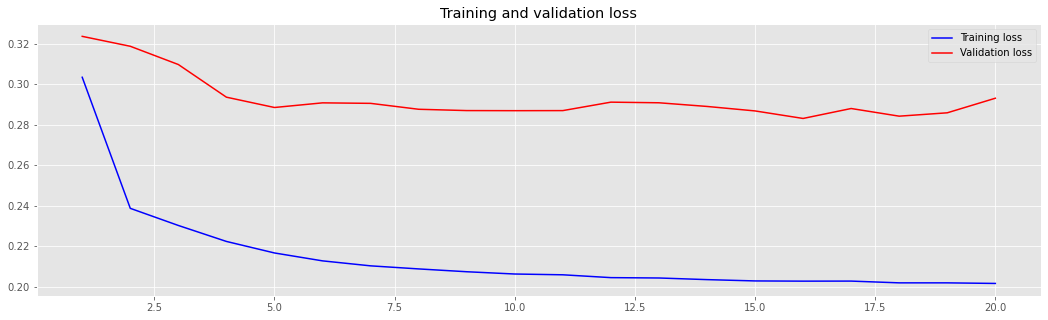

In [49]:
plot_history(model_pipe.named_steps['blender'].history)

## We will not do cross validation due to the high time complexity but only evaluate on stratisfied train_test_split.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_prep, encoded_labels, test_size=0.25, \
                                                    stratify=encoded_labels, random_state=1)

In [51]:
cnn_model2 = NLPModel(build_cnn_model, 'cnn_model', epochs=7)

In [52]:
lstm_model2 = NLPModel(build_lstm_model, 'lstm_model', epochs=10)

In [53]:
union2 = FeatureUnion([('cnn_model', cnn_model2), ('lstm_model', lstm_model2)])

In [54]:
model2 = BlenderModel(build_blender, epochs=9) # best epoch from model

In [55]:
model_pipe2 = Pipeline([('union', union2), ('blender', model2)], verbose=1)

In [56]:
model_pipe2.fit(X_train, y_train);

Done training Word2Vec for cnn_model                    total: 1.8mins
Done training cnn_model model                           total: 0.7mins
Done training Word2Vec for lstm_model                    total: 1.8mins
Done training lstm_model model                           total: 4.4mins
[Pipeline] ............. (step 1 of 2) Processing union, total= 9.2min
Epoch 1/9
936/936 [==============================] - 2s 3ms/step - loss: 0.3172 - accuracy: 0.9162 - multi_class_fbeta: 0.9159
Epoch 2/9
936/936 [==============================] - 3s 3ms/step - loss: 0.2483 - accuracy: 0.9236 - multi_class_fbeta: 0.9237
Epoch 3/9
936/936 [==============================] - 3s 4ms/step - loss: 0.2401 - accuracy: 0.9240 - multi_class_fbeta: 0.9240
Epoch 4/9
936/936 [==============================] - 3s 3ms/step - loss: 0.2343 - accuracy: 0.9245 - multi_class_fbeta: 0.9247
Epoch 5/9
936/936 [==============================] - 2s 3ms/step - loss: 0.2295 - accuracy: 0.9249 - multi_class_fbeta: 0.9249
Epoch 6/

In [57]:
y_pred_train = model_pipe2.predict(X_train)
y_pred_test = model_pipe2.predict(X_test)

312/312 [==============================] - 0s 1ms/step


In [58]:
acc_train = accuracy_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train, average='weighted')

acc_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, average='weighted')

In [59]:
print('Training accuracy: {:.4f}\nTraining f1_score: {:.4f}'.format(acc_train, f1_train))
print()
print('Testing accuracy: {:.4f}\nTesting f1_score: {:.4f}'.format(acc_test, f1_test))

Training accuracy: 0.9258
Training f1_score: 0.9259

Testing accuracy: 0.8794
Testing f1_score: 0.8796


## Our blended model seem to slightly perform better both CNN and LSTM whose f1_scores for the testting set are 0.85 and 0.876 repectively. Improved the LSTM's f1_score by 0.03.